In [65]:
#for paper2: compare our analytical model anti-symmetric power spectrum with Zhou's simulation result,
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
import time
import os
from scipy.interpolate import interp1d, interp2d

import antisym_func
import error_bar #Tan
import error #Zhou

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
from importlib import reload
reload(error_bar); reload(error)

<module 'error' from '/Users/liuzhaoning/Desktop/Today/antisym_observability/pycode/error.py'>

In [50]:
#calculate the Pk_A for certain models at input redshift array
def read_model_data(DIR, zeta, T_vir, R_mfp, SMOOTHING_SCALE):
    #read in the normalized zeta
    DIR_zeta = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/normalized_zeta.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_zeta): 
        data = np.load(DIR_zeta)
        z_zeta_interp_array = data['z']; zeta_z_interp_array = data['zeta_z']
        zeta_z_func = interp1d(z_zeta_interp_array, zeta_z_interp_array, kind = 'cubic')
    else:
        print('file %s not found'%DIR_zeta); sys.exit()
        
    #read in the history of HI fraction and dx_HI/dz
    DIR_history = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/history.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_history):
        data = np.load(DIR_history)
        z_array_history = list(data['z_array_history']); HI_history = list(data['HI_history'])
        z_dxHdz_history = list(data['z_dxHdz_history']); dxHdz_history = list(data['dxHdz_history'])
    else:
        print('file %s not found'%DIR_history); sys.exit()
    
    #read in the average density of the neutral region
    DIR_rhoHI = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/rhoHI_over_rho0.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_rhoHI):
        data = np.load(DIR_rhoHI)
        z_array_HIrho = list(data['z_array_HIrho']); rhoHI_over_rho0_array = list(data['rhoHI_over_rho0_array'])
        HIrho_over_rho0_interp = interp1d(z_array_HIrho, rhoHI_over_rho0_array, kind = 'cubic')
    else:
        print('file %s not found'%DIR_rhoHI); sys.exit()
    
    #load in the Bubble mass functions
    DIR_BMF = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/BMF_map.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_BMF):
        data = np.load(DIR_BMF)
        z_grid = list(data['z_grid']); m_grid = list(data['m_grid']); BMF_map = list(data['BMF_map'])       
        BMF_interp = interp2d(m_grid, z_grid, BMF_map, kind = 'cubic')
    else:
        print('file %s not found'%DIR_BMF); sys.exit()
    
    #load in the unsmoothed antisymmetric cross-correlation data
    DIR_xiHICO = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/xi_A_HICO_unsmoothed_map.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_xiHICO):
        data = np.load(DIR_xiHICO)
        z_grid = list(data['z_grid']); r12_grid = list(data['r12_grid']); xi_A_HICO_map = list(data['xi_A_HICO_map'])       
        xi_A_HICO_unsmoothed_interp = interp2d(r12_grid, z_grid, xi_A_HICO_map, kind = 'cubic')
    else:
        print('file %s not found'%DIR_xiHICO); sys.exit()
    return zeta_z_func, z_array_history, HI_history, z_dxHdz_history, dxHdz_history, HIrho_over_rho0_interp, \
            BMF_interp, xi_A_HICO_unsmoothed_interp

def observation_parameters(z, NUM_PATCH, t_int, SMOOTHING_Pk, MEASUREMENT):
    """
    set the parameters for observation
    -----------
    Parameters:
    -----------
    z : redshift
    NUM_PATCH : number of observation boxes
    t_int : seconds, the observation time for the two lines
    MEASUREMENT: 0, 1, 2 for SKA1, SKA2 and SKA2-advanced
    """
    #set the parameters
    Tsys_21 = 280. * ( (1. + z) / 7.4 )**(2.3) * 1e6 # muK
    Tsys_CO = 25 * 1e6 # muK
    D_21 = 35; D_CO = 15 # meter 
    Omega_beam_21 = (1.22 * error.lambda_21 * (1 + z) / D_21 ) ** 2
    Omega_beam_CO = (1.22 * error.lambda_CO * (1 + z) / D_CO ) ** 2 # radians
    delta_nu_21 = 5.4e-3; delta_nu_CO = 79.3e-3 #MHz
    
    #set the Parameters of telescopes
    if MEASUREMENT == 0: #parameters of SKA1 
        N_feeds_21 = 2 # num of polarizations
        N_feeds_CO = 197 * 2 # num of antennas * num of polarizations
        L_min_21 = 60; L_max_21 = 1000 #m
    elif MEASUREMENT == 1: #parameters of SKA2
        N_feeds_21 = 2 * 4 # fourtimes of the antennas than SKA1-low
        N_feeds_CO = 1970 * 2 # num of antennas * num of polarizations
        L_min_21 = 34; L_max_21 = 1000
    elif MEASUREMENT == 2: #parameters of SKA2-advanced
        N_feeds_21 = 2 * 4 # fourtimes of the antennas than SKA1-low
        N_feeds_CO = 4925 * 2 # num of antennas * num of polarizations
        L_min_21 = 34; L_max_21 = 1000
    
    #SMOOTHING_Pk defines the box size
    Omega_patch = (SMOOTHING_Pk * antisym_func.hlittle / error.X(z)) ** 2
    Omega_survey = NUM_PATCH * Omega_patch
    delta_D = SMOOTHING_Pk * antisym_func.hlittle 
    return Omega_patch, NUM_PATCH, Tsys_CO, Tsys_21, Omega_beam_CO, Omega_beam_21, delta_nu_CO, \
            delta_nu_21, N_feeds_CO, N_feeds_21, t_int, t_int, delta_D, L_min_21, L_max_21

In [127]:
dxHdz_ana_acc

[0.222,
 0.238,
 0.246,
 0.255,
 0.271,
 0.288,
 0.304,
 0.312,
 0.321,
 0.337,
 0.354,
 0.371,
 0.378]

In [110]:
#set the common parameters of analytical models
R_mfp = 50; M_max = antisym_func.RtoM(R_mfp); SMOOTHING_SCALE = 384; mu = 0.6
zeta_sets = [32.5, 47, 37.5, 32.5]; T_vir_sets = [5e4, 5e4, 4.1e4, 6.67e4]

#read in the analytical HI-CO dipole
data_acc = []; data_dec = [] # ['black', 'green', 'blue', 'cyan']
for ct in range(4):
    data_acc.append(np.load('../data/antisym_observability/Pk_A_model_examination/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/Pk_A_acc_array.npz'%(zeta_sets[ct], T_vir_sets[ct], 50, 384)))
    data_dec.append(np.load('../data/antisym_observability/Pk_A_model_examination/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/Pk_A_dec_array.npz'%(zeta_sets[ct], T_vir_sets[ct], 50, 384)))
dxHdz_ana_acc = list(data_acc[0]['dxHdz_xi_acc_smoothed_array']) #correspondent to the redshift z array
dxHdz_ana_dec = list(data_dec[0]['dxHdz_xi_dec_smoothed_array'])
kh_array = list(data_acc[0]['kh_array'])

z_ana_acc = []; z_ana_dec = [] #[model][redshift]
Pk_A_acc = []; Pk_A_dec = [] #[model][redshift][kh]
for ct in range(4):
    z_ana_acc.append(list(data_acc[ct]['z_xi_acc_smoothed_array']))
    z_ana_dec.append(list(data_dec[ct]['z_xi_dec_smoothed_array']))
    Pk_A_acc.append(list(data_acc[ct]['Pk_A_acc_map']))
    Pk_A_dec.append(list(data_dec[ct]['Pk_A_dec_map']))

#read in the history and the HI-CO anti-symmtric cross correlation of the four analytical models
DIR = '/Users/liuzhaoning/Desktop/Today/antisym_observability/data/antisym_observability/xi_A_HICO'
zeta_z_func, z_HI_ana, HI_ana, z_dxHdz_ana, dxHdz_ana, HIrho_over_rho0_interp, BMF_interp, \
xi_A_HICO_unsmoothed_interp = [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0]
for ct in range(4):
    zeta_z_func[ct], z_HI_ana[ct], HI_ana[ct], z_dxHdz_ana[ct], dxHdz_ana[ct], HIrho_over_rho0_interp[ct], BMF_interp[ct], \
    xi_A_HICO_unsmoothed_interp[ct] = read_model_data(DIR, zeta_sets[ct], T_vir_sets[ct], R_mfp, SMOOTHING_SCALE)

#compute the 21cm and CO auto power spectrum and the symmetric HI-CO cross power spectrum
#at certain dxH/dz
r12_limit = 150; r12_grid = np.zeros(100); r12_grid[0:30] = np.linspace(0.1, 5, 30)
r12_grid[30:100] = np.linspace(5, r12_limit, 71)[1:71]
Pk_A_acc_ana, Pk_A_dec_ana = [], [] #[model][dxHdz (0.246, 0.312, 0.378)][kh]
Pk_A_acc_var_ZHOU, Pk_A_dec_var_ZHOU = [], [] #[model][dxHdz][kh]
Pk_A_acc_var_TAN, Pk_A_dec_var_TAN = [], [] #[model][dxHdz][kh]
for ct in range(4):
    Pk_A_acc_ana.append([]); Pk_A_dec_ana.append([])
    Pk_A_acc_var_ZHOU.append([]); Pk_A_dec_var_ZHOU.append([])
    Pk_A_acc_var_TAN.append([]); Pk_A_dec_var_TAN.append([])
    for z_index in range(len(z_ana_acc[ct])):
        z = z_ana_acc[ct][z_index]; dxHdz = dxHdz_ana_acc[z_index]
        if dxHdz in [0.246, 0.312, 0.378]:
            tick = time.time()
            #set the observation parameters
            Omega_patch, NUM_PATCH, Tsys_CO, Tsys_21, Omega_beam_CO, Omega_beam_21, delta_nu_CO, \
            delta_nu_21, Nfeeds_CO, Nfeeds_21, t_int_CO, t_int_21, delta_D, L_min_21, L_max_21 \
                = observation_parameters(z, NUM_PATCH = 100, t_int = 3000 * 3600, SMOOTHING_Pk = 384, MEASUREMENT = 0)
            Pk_A_acc_ana[-1].append([]); Pk_A_acc_var_ZHOU[-1].append([]); Pk_A_acc_var_TAN[-1].append([])
            xi_S_HICO_array, xi_auto_21_array = [], []
            for r12 in r12_grid:
                xi_S_HICO_array.append(antisym_func.xi_S_HICO(z, r12, zeta_z_func[ct], HIrho_over_rho0_interp[ct], lambda m: BMF_interp[ct](m, z), M_max, T_vir_sets[ct], mu))
                xi_auto_21_array.append(antisym_func.xi_auto_21(z, r12, zeta_z_func[ct], HIrho_over_rho0_interp[ct], lambda m: BMF_interp[ct](m, z), M_max, T_vir_sets[ct], mu))
            xi_S_HICO_func = interp1d(r12_grid, xi_S_HICO_array, kind = 'cubic')
            xi_auto_21_func = interp1d(r12_grid, xi_auto_21_array, kind = 'cubic')
            for kh_index in range(len(kh_array)):
                kh = kh_array[kh_index] # h/Mpc
                delta_kh = kh*0.1
                k = kh * antisym_func.hlittle # /Mpc
                P_CO_ana = antisym_func.Pk_auto_CO(z, k, T_vir_sets[ct], mu)
                P_21_ana = antisym_func.Pk_S(k, xi_auto_21_func, min(r12_grid), max(r12_grid))
                P_sym_ana = antisym_func.Pk_S(k, xi_S_HICO_func, min(r12_grid), max(r12_grid))
                Pk_A_acc_ana[-1][-1].append(Pk_A_acc[ct][z_index][kh_index])
                Pk_A_acc_var_TAN[-1][-1].append(error_bar.VAR_PA_k(kh, delta_kh, z, Omega_patch, NUM_PATCH, Tsys_CO, Tsys_21, \
                        Omega_beam_CO, Omega_beam_21, delta_nu_CO, delta_nu_21, Nfeeds_CO, Nfeeds_21, t_int_CO, \
                        t_int_21, delta_D, L_min_21, L_max_21, P_CO_ana, P_21_ana, P_sym_ana, Pk_A_acc[ct][z_index][kh_index])[1])
                Pk_A_acc_var_ZHOU[-1][-1].append(error.VAR_PA_k(kh, delta_kh, z, Omega_patch, NUM_PATCH, Tsys_CO, Tsys_21, \
                        Omega_beam_CO, Omega_beam_21, delta_nu_CO, delta_nu_21, Nfeeds_CO, Nfeeds_21, t_int_CO, \
                        t_int_21, delta_D, L_min_21, L_max_21, P_CO_ana, P_21_ana, P_sym_ana, Pk_A_acc[ct][z_index][kh_index])[1])
                #print('%3.3g, %3.3g, %3.3g'%(Pk_A_acc_var[-1][-1][-1], Pk_A_acc[ct][z_index][kh_index], Pk_A_acc_var[-1][-1][-1] / Pk_A_acc[ct][z_index][kh_index]))
            print('model %d at dxH/dz = %3.3g (acceleration) cost %3.3g mins'%(ct, dxHdz, (time.time() - tick) / 60))
    for z_index in range(len(z_ana_dec[ct])):
        z_index = len(z_ana_dec[ct]) - z_index - 1 # to make sure that the dxHdz is in the order of (0.246, 0.312, 0.378)
        z = z_ana_dec[ct][z_index]; dxHdz = dxHdz_ana_dec[z_index]
        if dxHdz in [0.246, 0.312, 0.378]:
            tick = time.time()
            #set the observation parameters
            Omega_patch, NUM_PATCH, Tsys_CO, Tsys_21, Omega_beam_CO, Omega_beam_21, delta_nu_CO, \
            delta_nu_21, Nfeeds_CO, Nfeeds_21, t_int_CO, t_int_21, delta_D, L_min_21, L_max_21 \
                = observation_parameters(z, NUM_PATCH = 100, t_int = 3000 * 3600, SMOOTHING_Pk = 384, MEASUREMENT = 0)
            Pk_A_dec_ana[-1].append([]); Pk_A_dec_var_ZHOU[-1].append([]); Pk_A_dec_var_TAN[-1].append([])
            xi_S_HICO_array, xi_auto_21_array = [], []
            for r12 in r12_grid:
                xi_S_HICO_array.append(antisym_func.xi_S_HICO(z, r12, zeta_z_func[ct], HIrho_over_rho0_interp[ct], lambda m: BMF_interp[ct](m, z), M_max, T_vir_sets[ct], mu))
                xi_auto_21_array.append(antisym_func.xi_auto_21(z, r12, zeta_z_func[ct], HIrho_over_rho0_interp[ct], lambda m: BMF_interp[ct](m, z), M_max, T_vir_sets[ct], mu))
            xi_S_HICO_func = interp1d(r12_grid, xi_S_HICO_array, kind = 'cubic')
            xi_auto_21_func = interp1d(r12_grid, xi_auto_21_array, kind = 'cubic')
            for kh_index in range(len(kh_array)):
                kh = kh_array[kh_index] # h/Mpc
                delta_kh = kh*0.1
                k = kh * antisym_func.hlittle # /Mpc
                P_CO_ana = antisym_func.Pk_auto_CO(z, k, T_vir_sets[ct], mu)
                P_21_ana = antisym_func.Pk_S(k, xi_auto_21_func, min(r12_grid), max(r12_grid))
                P_sym_ana = antisym_func.Pk_S(k, xi_S_HICO_func, min(r12_grid), max(r12_grid))
                Pk_A_dec_ana[-1][-1].append(Pk_A_dec[ct][z_index][kh_index])
                Pk_A_dec_var_TAN[-1][-1].append(error_bar.VAR_PA_k(kh, delta_kh, z, Omega_patch, NUM_PATCH, Tsys_CO, Tsys_21, \
                        Omega_beam_CO, Omega_beam_21, delta_nu_CO, delta_nu_21, Nfeeds_CO, Nfeeds_21, t_int_CO, \
                        t_int_21, delta_D, L_min_21, L_max_21, P_CO_ana, P_21_ana, P_sym_ana, Pk_A_acc[ct][z_index][kh_index])[1])
                Pk_A_dec_var_ZHOU[-1][-1].append(error.VAR_PA_k(kh, delta_kh, z, Omega_patch, NUM_PATCH, Tsys_CO, Tsys_21, \
                        Omega_beam_CO, Omega_beam_21, delta_nu_CO, delta_nu_21, Nfeeds_CO, Nfeeds_21, t_int_CO, \
                        t_int_21, delta_D, L_min_21, L_max_21, P_CO_ana, P_21_ana, P_sym_ana, Pk_A_acc[ct][z_index][kh_index])[1])
                #print('%3.3g, %3.3g, %3.3g'%(Pk_A_acc_var[-1][-1][-1], Pk_A_acc[ct][z_index][kh_index], Pk_A_acc_var[-1][-1][-1] / Pk_A_acc[ct][z_index][kh_index]))
            print('model %d at dxH/dz = %3.3g (deceleration) cost %3.3g mins'%(ct, dxHdz, (time.time() - tick) / 60))
        

model 0 at dxH/dz = 0.246 (acceleration) cost 0.298 mins
model 0 at dxH/dz = 0.312 (acceleration) cost 0.329 mins
model 0 at dxH/dz = 0.378 (acceleration) cost 0.357 mins
model 0 at dxH/dz = 0.246 (deceleration) cost 0.351 mins
model 0 at dxH/dz = 0.312 (deceleration) cost 0.347 mins
model 0 at dxH/dz = 0.378 (deceleration) cost 0.333 mins
model 1 at dxH/dz = 0.246 (acceleration) cost 0.293 mins
model 1 at dxH/dz = 0.312 (acceleration) cost 0.302 mins
model 1 at dxH/dz = 0.378 (acceleration) cost 0.334 mins
model 1 at dxH/dz = 0.246 (deceleration) cost 0.351 mins
model 1 at dxH/dz = 0.312 (deceleration) cost 0.342 mins
model 1 at dxH/dz = 0.378 (deceleration) cost 0.339 mins
model 2 at dxH/dz = 0.246 (acceleration) cost 0.305 mins
model 2 at dxH/dz = 0.312 (acceleration) cost 0.333 mins
model 2 at dxH/dz = 0.378 (acceleration) cost 0.349 mins
model 2 at dxH/dz = 0.246 (deceleration) cost 0.362 mins
model 2 at dxH/dz = 0.312 (deceleration) cost 0.35 mins
model 2 at dxH/dz = 0.378 (decel

/Users/liuzhaoning/Desktop/Today/antisym_observability/pycode/antisym_func.py:632: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  P1 = integrate.quad(integrand, M_min, 0.999 * M_max, epsrel = 1e-4)[0] \


model 3 at dxH/dz = 0.378 (deceleration) cost 91.9 mins


In [96]:
#read in the simulation history of Zhou et al. (2021)
z_HI = np.loadtxt('../data/zhou/history/history_z.txt')
HI_simu_black = np.loadtxt('../data/zhou/history/history_HI_black.txt')
[z_dxHdz, dxHdz_simu_black] = antisym_func.dxH_dz_cal(z_HI, HI_simu_black)
HI_simu_green = np.loadtxt('../data/zhou/history/history_HI_green.txt')
[z_dxHdz, dxHdz_simu_green] = antisym_func.dxH_dz_cal(z_HI, HI_simu_green)
HI_simu_blue = np.loadtxt('../data/zhou/history/history_HI_blue.txt')
[z_dxHdz, dxHdz_simu_blue] = antisym_func.dxH_dz_cal(z_HI, HI_simu_blue)
HI_simu_cyan = np.loadtxt('../data/zhou/history/history_HI_cyan.txt')
[z_dxHdz, dxHdz_simu_cyan] = antisym_func.dxH_dz_cal(z_HI, HI_simu_cyan)

#the dxHdz of simulation compuation
dxHdz_acc_antisym = np.loadtxt('../data/zhou/dxdz_zhou_acc_ana.txt')
dxHdz_dec_antisym = np.loadtxt('../data/zhou/dxdz_zhou_dec_ana.txt')

#read in the simulation HI-CO dipole and the cosmic variance
filename = ['black', 'green', 'blue', 'cyan']
kh_acc_simu = []; Pk_A_acc_simu = []; Pk_A_acc_simu_var = [] #[dxHdz][color][kh]
for dxHdz in [246, 312, 378]:
    with open('../data/zhou/pa384Mpcdxdz%dlgaccel.txt'%dxHdz, 'r', encoding='utf-8') as file:
        kh_acc_simu.append([]); Pk_A_acc_simu.append([]); Pk_A_acc_simu_var.append([])
        for ct in range(4):
            Pk_A_acc_simu[-1].append([]); Pk_A_acc_simu_var[-1].append([])
        i = 0
        for line in file:
            if (i >= 1 and i <= 16):
                data_line = line.strip("\n").split()
                kh_acc_simu[-1].append(float(data_line[0]))
                for ct in range(4):
                    Pk_A_acc_simu[-1][ct].append(float(data_line[ct * 2 + 1]))
                    Pk_A_acc_simu_var[-1][ct].append(float(data_line[ct * 2 + 2]))
            i += 1
    
kh_dec_simu = []; Pk_A_dec_simu = []; Pk_A_dec_simu_var = [] #[dxHdz][color][kh]
for dxHdz in [246, 312, 378]:
    with open('../data/zhou/pa384Mpcdxdz%dlgdecel.txt'%dxHdz, 'r', encoding='utf-8') as file:
        kh_dec_simu.append([]); Pk_A_dec_simu.append([]); Pk_A_dec_simu_var.append([])
        if (dxHdz == 378):
            for ct in range(4):
                Pk_A_dec_simu[-1].append([]); Pk_A_dec_simu_var[-1].append([])
            i = 0
            for line in file:
                if (i >= 1 and i <= 16):
                    data_line = line.strip("\n").split()
                    kh_dec_simu[-1].append(float(data_line[0]))
                    for ct in range(4):
                        Pk_A_dec_simu[-1][ct].append(float(data_line[ct * 2 + 1]))
                        Pk_A_dec_simu_var[-1][ct].append(float(data_line[ct * 2 + 2]))
                i += 1
        else:
            for ct in range(4):
                Pk_A_dec_simu[-1].append([]); Pk_A_dec_simu_var[-1].append([])
            i = 0
            for line in file:
                if (i >= 1 and i <= 16):
                    data_line = line.strip("\n").split()
                    kh_dec_simu[-1].append(float(data_line[0]))
                    for ct in range(3):
                        Pk_A_dec_simu[-1][ct].append(float(data_line[ct * 2 + 1]))
                        Pk_A_dec_simu_var[-1][ct].append(float(data_line[ct * 2 + 2]))
                if (i >= 1 and i <= 9):
                    data_line = line.strip("\n").split()
                    kh_acc_simu[-1].append(float(data_line[0]))
                    Pk_A_dec_simu[-1][3].append(float(data_line[7]))
                    Pk_A_dec_simu_var[-1][3].append(float(data_line[8]))   
                i += 1

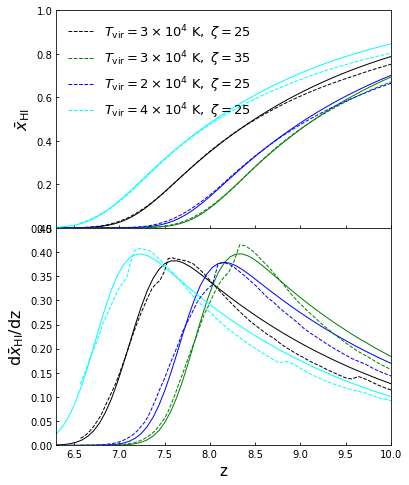

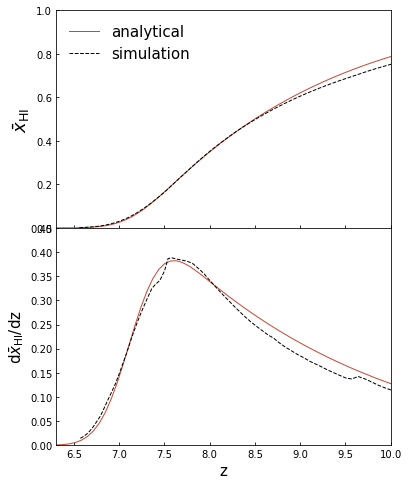

In [101]:
#plot the history
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6,8))
fig.subplots_adjust(hspace=0)
    
axs[0].tick_params(direction='in',length=3)
for i in range(4):
    axs[0].plot(z_HI_ana[i], HI_ana[i], color = filename[i], lw=1, ls='-')
axs[0].plot(z_HI, HI_simu_black, color = 'black', lw=1, ls='--', label=r'$T_\mathrm{vir} = 3\times10^4 \ \mathrm{K},\ \zeta=25 $')
axs[0].plot(z_HI, HI_simu_green, color = 'green', lw=1, ls='--', label=r'$T_\mathrm{vir} = 3\times10^4 \ \mathrm{K},\ \zeta=35 $')
axs[0].plot(z_HI, HI_simu_blue, color = 'blue', lw=1, ls='--', label=r'$T_\mathrm{vir} = 2\times10^4 \ \mathrm{K},\ \zeta=25 $')
axs[0].plot(z_HI, HI_simu_cyan, color = 'cyan', lw=1, ls='--', label=r'$T_\mathrm{vir} = 4\times10^4 \ \mathrm{K},\ \zeta=25 $')
axs[0].set_ylabel(r'$\bar{x}_{\mathrm{HI}}$',fontsize=16)
axs[0].set_ylim(0,1)
axs[0].legend(loc=2,fontsize=13, frameon = False)
  
for i in range(4):
    axs[1].plot(z_dxHdz_ana[i], dxHdz_ana[i], color = filename[i], lw=1, ls='-')
axs[1].plot(z_dxHdz, dxHdz_simu_black, color = 'black', lw=1, ls='--')
axs[1].plot(z_dxHdz, dxHdz_simu_green, color = 'green', lw=1, ls='--')
axs[1].plot(z_dxHdz, dxHdz_simu_blue, color = 'blue', lw=1, ls='--')
axs[1].plot(z_dxHdz, dxHdz_simu_cyan, color = 'cyan', lw=1, ls='--')
axs[1].set_ylim(0.0,0.45); axs[1].set_xlim(6.3,10)
axs[1].set_ylabel(r'd$\bar{x}_{\mathrm{HI}}$/dz',fontsize=16)
axs[1].set_xlabel('z',fontsize=15)
axs[1].tick_params(direction='in',length=3)
#axs[1].text(9, 0.35,'accel.',fontsize=14); axs[1].text(6.45, 0.35, 'decel.', fontsize = 14)
plt.savefig('../figures/history_comparison_all_models.png', bbox_inches='tight', dpi=200)

#plot for the presentation
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6,8))
fig.subplots_adjust(hspace=0)   
axs[0].tick_params(direction='in',length=3)
axs[0].plot(z_HI_ana[0], HI_ana[0], color = '#C34A36', lw=1, ls='-', label=r'analytical')
axs[0].plot(z_HI, HI_simu_black, color = 'black', lw=1, ls='--', label=r'simulation')
axs[0].set_ylabel(r'$\bar{x}_{\mathrm{HI}}$',fontsize=18)
axs[0].set_ylim(0,1)
axs[0].legend(loc=2,fontsize=15, frameon = False)
axs[1].plot(z_dxHdz_ana[0], dxHdz_ana[0], color = '#C34A36', lw=1, ls='-')
axs[1].plot(z_dxHdz, dxHdz_simu_black, color = 'black', lw=1, ls='--')
axs[1].set_ylim(0.0,0.45); axs[1].set_xlim(6.3,10)
axs[1].set_ylabel(r'd$\bar{x}_{\mathrm{HI}}$/dz',fontsize=15)
axs[1].set_xlabel('z',fontsize=15)
axs[1].tick_params(direction='in',length=3)
plt.savefig('../figures/history_comparison_presentation.png', bbox_inches='tight', dpi=200)

In [92]:
Pk_A_acc_simu[0][0][:3], Pk_A_acc_simu_var[0][0][:3]

([221409.1, 104813.4, 59556.97], [114535.8, 80371.18, 61312.49])

In [91]:
Pk_A_acc_ana[0][0][3:6], Pk_A_acc_var_ZHOU[0][0][3:6]

([118057.58815516804, 112150.66368353693, 99843.12119343806],
 [327264.05478465086, 225685.2977707248, 153498.05191931277])

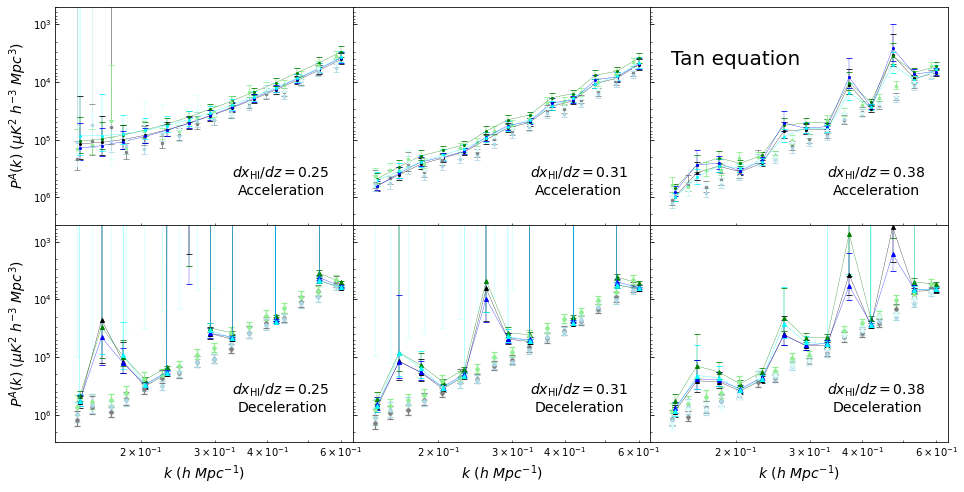

In [126]:
#plot the comparison
FONTSIZE = 14

fig, axs = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(16, 8))
fig.subplots_adjust(wspace=0, hspace=0)
dxHdz_array = [0.246, 0.312, 0.378]
lightcolor = ['grey', 'lightgreen', 'lightblue', 'lightcyan']
for i in range(3): # 3 different dxHdz
    for j in range(4): # 4 different models
        name = filename[j]
        #the analytical matrix is [model][dxHdz (0.246, 0.312, 0.378)][kh]
        axs[0, i].errorbar(kh_array[3:], Pk_A_acc_ana[j][i][3:], yerr = Pk_A_acc_var_TAN[j][i][3:], fmt = '.-', markersize = 4, linewidth = 0.3, capsize = 3, capthick = 0.8, color = '%s'%name)
        #the simulation matrix is [dxHdz (0.246, 0.312, 0.378)][model][kh]
        axs[0, i].errorbar(kh_acc_simu[0], Pk_A_acc_simu[i][j], yerr = Pk_A_acc_simu_var[i][j], fmt = '.', markersize = 5, elinewidth = 0.8,  capsize = 3, capthick = 0.8, color = '%s'%lightcolor[j])
    #the simulation result fitted line
    axs[0, i].text(0.33, 4.5e5, '$dx_\mathrm{HI} / dz = %2.2g$'%dxHdz_array[i], fontsize = FONTSIZE)
    axs[0, i].text(0.34, 9e5, 'Acceleration', fontsize=FONTSIZE)
axs[0, 0].set_ylabel(r'$P^A(k)$ ($\mu K^2\ h^{-3}$ $Mpc^{3}$)', fontsize = FONTSIZE)
axs[0, 0].set_ylabel(r'$P^A(k)$ ($\mu K^2\ h^{-3}$ $Mpc^{3}$)', fontsize = FONTSIZE)
axs[0, 0].set_yticks([1e3, 1e4, 1e5, 1e6])
axs[0, 0].set_yticklabels(['$-10^{3}$', '$-10^{4}$','$-10^{5}$','$-10^{6}$'])
axs[0, 0].set_ylim(5e2, 3e6)
axs[0, 0].set_yscale('log')
axs[0, 0].set_xscale('log')
axs[0, 2].text(0.14, 5e3, 'Tan equation', fontsize = 20)
#axs[0].legend(loc=2, fontsize=12)

for i in range(3):
    for j in range(4):
        name = filename[j]
        axs[1, i].errorbar(kh_array[3:], Pk_A_dec_ana[j][i][3:], yerr = Pk_A_dec_var_TAN[j][i][3:], fmt='^-', markersize = 4, linewidth = 0.3, capsize = 3, capthick = 0.8, color = '%s'%name)
        axs[1, i].errorbar(kh_dec_simu[0][:len(Pk_A_dec_simu[i][j])], Pk_A_dec_simu[i][j], yerr = Pk_A_dec_simu_var[i][j], fmt='.', markersize = 7, elinewidth = 1.2,  capsize = 3, capthick = 1.2, color = '%s'%lightcolor[j])
    #the simulation result fitted line
    axs[1, i].set_xlabel(r'$k\ (h\ Mpc^{-1})$',fontsize = FONTSIZE)
    axs[1, i].set_xticks([0.14,0.2,0.3,0.4,0.5,0.6])
    axs[1, i].set_xticklabels(['0.14','0.2','0.3','0.4','0.5','0.6'])
    axs[1, i].text(0.33, 4.5e5, '$dx_\mathrm{HI} / dz = %2.2g$'%dxHdz_array[i], fontsize = FONTSIZE)
    axs[1, i].set_xlim(0.125, 0.64)
    axs[1, i].text(0.34, 9e5, 'Deceleration', fontsize=FONTSIZE)
axs[1, 0].set_ylabel(r'$P^A(k)$ ($\mu K^2\ h^{-3}$ $Mpc^{3}$)', fontsize = FONTSIZE)
axs[1, 0].set_ylabel(r'$P^A(k)$ ($\mu K^2\ h^{-3}$ $Mpc^{3}$)', fontsize = FONTSIZE)
axs[1, 0].set_yticks([1e3, 1e4, 1e5, 1e6])
axs[1, 0].set_yticklabels(['$-10^{3}$', '$-10^{4}$','$-10^{5}$','$-10^{6}$'])
axs[1, 0].set_ylim(5e2, 3e6)
axs[1, 0].invert_yaxis()
axs[1, 0].set_yscale('log')
axs[1, 0].set_xscale('log')
#axs[0].legend(loc=3, fontsize=12)
fig.savefig('../figures/Pk_A_smoothed_synthesis.png', bbox_inches='tight', dpi=400)

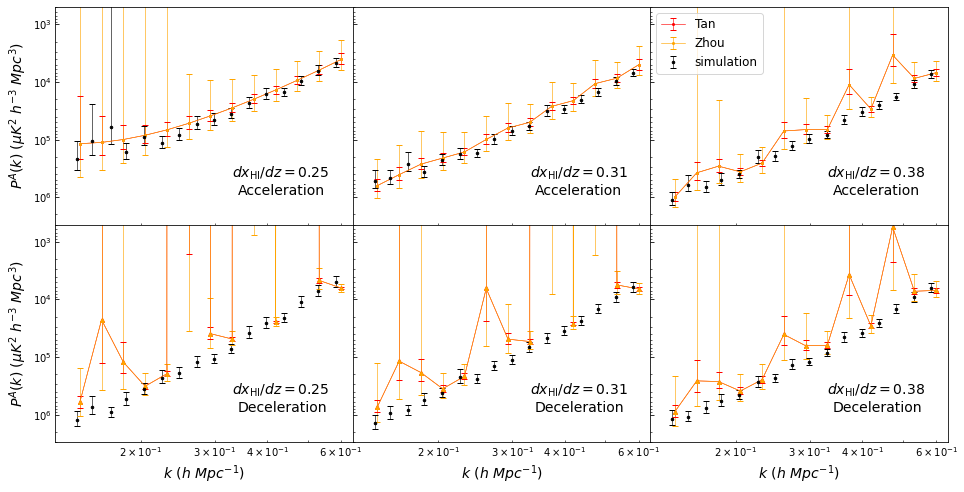

In [125]:
#plot the comparison
FONTSIZE = 14

fig, axs = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(16, 8))
fig.subplots_adjust(wspace=0, hspace=0)
dxHdz_array = [0.246, 0.312, 0.378]
lightcolor = ['grey', 'lightgreen', 'lightblue', 'lightcyan']
for i in range(3): # 3 different dxHdz
    name = filename[j]
    #the analytical matrix is [model][dxHdz (0.246, 0.312, 0.378)][kh]
    axs[0, i].errorbar(kh_array[3:], Pk_A_acc_ana[0][i][3:], yerr = Pk_A_acc_var_TAN[0][i][3:], fmt = '.-', markersize = 4, linewidth = 0.6, capsize = 3, capthick = 1, color = 'red', label = 'Tan')
    axs[0, i].errorbar(kh_array[3:], Pk_A_acc_ana[0][i][3:], yerr = Pk_A_acc_var_ZHOU[0][i][3:], fmt = '.-', markersize = 4, linewidth = 0.6, capsize = 3, capthick = 1, color = 'orange', label = 'Zhou')
    #the simulation matrix is [dxHdz (0.246, 0.312, 0.378)][model][kh]
    axs[0, i].errorbar(kh_acc_simu[0], Pk_A_acc_simu[i][0], yerr = Pk_A_acc_simu_var[i][0], fmt = '.', markersize = 5, linewidth = 0.6,  capsize = 3, capthick = 1, color = 'black', label = 'simulation')
    #the simulation result fitted line
    axs[0, i].text(0.33, 4.5e5, '$dx_\mathrm{HI} / dz = %2.2g$'%dxHdz_array[i], fontsize = FONTSIZE)
    axs[0, i].text(0.34, 9e5, 'Acceleration', fontsize=FONTSIZE)
axs[0, 0].set_ylabel(r'$P^A(k)$ ($\mu K^2\ h^{-3}$ $Mpc^{3}$)', fontsize = FONTSIZE)
axs[0, 0].set_ylabel(r'$P^A(k)$ ($\mu K^2\ h^{-3}$ $Mpc^{3}$)', fontsize = FONTSIZE)
axs[0, 0].set_yticks([1e3, 1e4, 1e5, 1e6])
axs[0, 0].set_yticklabels(['$-10^{3}$', '$-10^{4}$','$-10^{5}$','$-10^{6}$'])
axs[0, 0].set_ylim(5e2, 3e6)
axs[0, 0].set_yscale('log')
axs[0, 0].set_xscale('log')
axs[0, 2].legend(loc=2, fontsize=12)

for i in range(3):
    name = filename[j]
    axs[1, i].errorbar(kh_array[3:], Pk_A_dec_ana[0][i][3:], yerr = Pk_A_dec_var_TAN[0][i][3:], fmt='^-', markersize = 4, linewidth = 0.6, capsize = 3, capthick = 1, color = 'red')
    axs[1, i].errorbar(kh_array[3:], Pk_A_dec_ana[0][i][3:], yerr = Pk_A_dec_var_ZHOU[0][i][3:], fmt='^-', markersize = 4, linewidth = 0.6, capsize = 3, capthick = 1, color = 'orange')
    axs[1, i].errorbar(kh_dec_simu[0][:len(Pk_A_dec_simu[i][0])], Pk_A_dec_simu[i][0], yerr = Pk_A_dec_simu_var[i][0], fmt='.', markersize = 5, linewidth = 0.6,  capsize = 3, capthick = 1, color = 'black')
    #the simulation result fitted line
    axs[1, i].set_xlabel(r'$k\ (h\ Mpc^{-1})$',fontsize = FONTSIZE)
    axs[1, i].set_xticks([0.14,0.2,0.3,0.4,0.5,0.6])
    axs[1, i].set_xticklabels(['0.14','0.2','0.3','0.4','0.5','0.6'])
    axs[1, i].text(0.33, 4.5e5, '$dx_\mathrm{HI} / dz = %2.2g$'%dxHdz_array[i], fontsize = FONTSIZE)
    axs[1, i].set_xlim(0.125, 0.64)
    axs[1, i].text(0.34, 9e5, 'Deceleration', fontsize=FONTSIZE)
axs[1, 0].set_ylabel(r'$P^A(k)$ ($\mu K^2\ h^{-3}$ $Mpc^{3}$)', fontsize = FONTSIZE)
axs[1, 0].set_ylabel(r'$P^A(k)$ ($\mu K^2\ h^{-3}$ $Mpc^{3}$)', fontsize = FONTSIZE)
axs[1, 0].set_yticks([1e3, 1e4, 1e5, 1e6])
axs[1, 0].set_yticklabels(['$-10^{3}$', '$-10^{4}$','$-10^{5}$','$-10^{6}$'])
axs[1, 0].set_ylim(5e2, 3e6)
axs[1, 0].invert_yaxis()
axs[1, 0].set_yscale('log')
axs[1, 0].set_xscale('log')
#axs[0].legend(loc=3, fontsize=12)
fig.savefig('../figures/Pk_A_smoothed_synthesis_presentation.png', bbox_inches='tight', dpi=400)

In [13]:
#load in the data of Zhou et al. (2021)
nR_zhou_acc = np.loadtxt('../data/zhou/nR_zhou_acc.txt')
dxHdz_zhou_acc = np.loadtxt('../data/zhou/dxdz_zhou_acc.txt')
nR_error_zhou_acc = np.loadtxt('../data/zhou/nR_error_zhou_acc.txt')

nR_zhou_dec = np.loadtxt('../data/zhou/nR_zhou_dec.txt')
dxHdz_zhou_dec = np.loadtxt('../data/zhou/dxdz_zhou_dec.txt')
nR_error_zhou_dec = np.loadtxt('../data/zhou/nR_error_zhou_dec.txt')

#calculate the powerlaw index n_R
kh_floor = 3; kh_ceil = 9 #in the range of (0.14, 0.27)
A_R_acc = []; n_R_acc = []; n_R_error_acc = []
kh_array_fitting = []; Pk_A_acc_fitting = []; Pk_A_dec_fitting = []
for i in range(len(filename)):
    for kh in kh_array[kh_floor:kh_ceil]:
        kh_array_fitting.append(kh)
    for j in range(len(z_ana_acc[0])):
        if (i == 0): Pk_A_acc_fitting.append([])
        for Pk in Pk_A_acc[i][j][kh_floor:kh_ceil]:
            Pk_A_acc_fitting[j].append(Pk)
    for j in range(len(z_ana_dec[0])):
        if (i == 0): Pk_A_dec_fitting.append([])
        for Pk in Pk_A_dec[i][j][kh_floor:kh_ceil]:
            Pk_A_dec_fitting[j].append(Pk)

fitting_measure = 2
for i in range(len(z_ana_acc[0])):
    A_R_acc.append(antisym_func.fit_nR(kh_array_fitting, Pk_A_acc_fitting[i], fitting_measure)[0])
    n_R_acc.append(antisym_func.fit_nR(kh_array_fitting, Pk_A_acc_fitting[i], fitting_measure)[1])
    n_R_error_acc.append(antisym_func.fit_nR(kh_array_fitting, Pk_A_acc_fitting[i], fitting_measure)[3])
    
A_R_dec = []; n_R_dec = []; n_R_error_dec = []
for i in range(len(z_ana_dec[0])):
    A_R_dec.append(antisym_func.fit_nR(kh_array_fitting, Pk_A_dec_fitting[i], fitting_measure)[0])
    n_R_dec.append(antisym_func.fit_nR(kh_array_fitting, Pk_A_dec_fitting[i], fitting_measure)[1])
    n_R_error_dec.append(antisym_func.fit_nR(kh_array_fitting, Pk_A_dec_fitting[i], fitting_measure)[3])

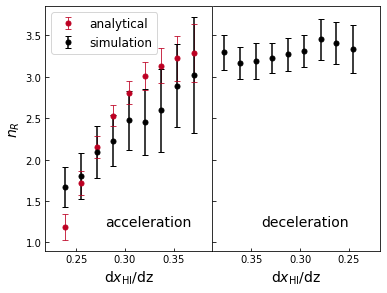

In [18]:
#remove points without simulation counterparts
dxHdz_acc_antisym_plot = list(dxHdz_acc_antisym); n_R_acc_plot = list(n_R_acc); n_R_error_acc_plot = list(n_R_error_acc)
dxHdz_acc_antisym_plot.pop(2); dxHdz_acc_antisym_plot.pop(6); dxHdz_acc_antisym_plot.pop(10)
n_R_acc_plot.pop(2); n_R_acc_plot.pop(6); n_R_acc_plot.pop(10)
n_R_error_acc_plot.pop(2); n_R_error_acc_plot.pop(6); n_R_error_acc_plot.pop(10)

#plot the n_R comparison
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6, 4.5))
fig.subplots_adjust(wspace=0)

colorlist = ['#0000a5', '#5e6395', '#86b178', '#ffed00']
axs[0].errorbar(dxHdz_acc_antisym_plot[1:], n_R_acc_plot[1:], yerr = n_R_error_acc_plot[1:], fmt='o', markersize = 5, elinewidth = 0.8,  capsize = 3, capthick = 0.8, color = '#bd0022', label = 'analytical')
#axs[1].errorbar(dxHdz_dec_antisym, n_R_dec, yerr = n_R_error_dec, fmt='o', markersize = 5, elinewidth = 0.8, capsize = 3, capthick = 0.8, color = '#bd0022', label = 'analytical')
axs[0].errorbar(dxHdz_zhou_acc[1:], nR_zhou_acc[1:], yerr = nR_error_zhou_acc[1:], fmt='o', markersize = 5, capsize = 3, color = 'black', label = 'simulation')
axs[1].errorbar(dxHdz_zhou_dec, nR_zhou_dec, yerr = nR_error_zhou_dec, fmt='o', markersize = 5, capsize = 3, color = 'black', label = 'simulation')

axs[0].legend(fontsize=12, loc=2)
axs[1].set_xlim(0.218,0.39)
axs[1].invert_xaxis()
axs[0].set_xlabel(r'd$x_\mathrm{HI}$/dz',fontsize=14)
axs[1].set_xlabel(r'd$x_\mathrm{HI}$/dz',fontsize=14)
axs[0].text(0.28, 1.2, 'acceleration',fontsize = 14)
axs[1].text(0.34, 1.2, 'deceleration',fontsize = 14)
axs[0].set_ylabel(r'$n_R$',fontsize=14)
axs[0].set_xlim(0.218,0.39)
#axs[0].set_ylim(0.6,4.2)
fig.savefig('../figures/nR_synthesis.png',dpi=200)